# Project 2 - Machine Learning

## Document content exploration

In [1]:
# Library Importation.
import numpy as np
import pandas as pd
import random as rd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer


from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers

from collections import Counter

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.decomposition import NMF

from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense
from keras.models import Sequential

from keras.utils.np_utils import to_categorical

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import files
files.upload()

### Import Data

In [4]:
# Lecture of the data frame
Corona_test = pd.read_csv('Corona_NLP_test.csv',encoding="latin1")
Corona_train = pd.read_csv('Corona_NLP_train.csv',encoding="latin1")
# Give the size of the dataset
print(Corona_test.shape)
print(Corona_train.shape)

(3798, 6)
(41157, 6)


In [5]:
Corona_test.head(5)

UserName  ...           Sentiment
0         1  ...  Extremely Negative
1         2  ...            Positive
2         3  ...  Extremely Positive
3         4  ...            Negative
4         5  ...             Neutral

[5 rows x 6 columns]

In [6]:
Corona_train.head(5)

UserName  ...           Sentiment
0      3799  ...             Neutral
1      3800  ...            Positive
2      3801  ...            Positive
3      3802  ...            Positive
4      3803  ...  Extremely Negative

[5 rows x 6 columns]

### Distribution of Sentiment

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


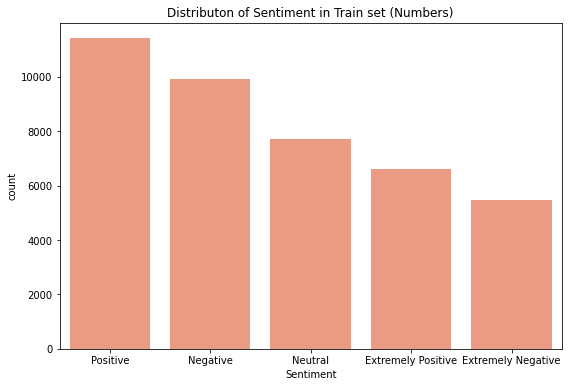

In [7]:
# Distribution of Sentiment in train set and test set (Count numbers)

plt.figure(figsize=(9, 6))
train=sns.countplot(Corona_train['Sentiment'], data=Corona_train,order = Corona_train['Sentiment'].value_counts().index,color='#fc9272').set_title("Distributon of Sentiment in Train set (Numbers)")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


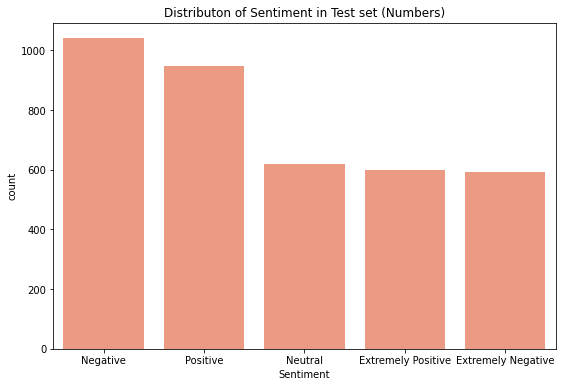

In [8]:
plt.figure(figsize=(9, 6))
test=sns.countplot(Corona_test['Sentiment'], data=Corona_test,order = Corona_test['Sentiment'].value_counts().index,color='#fc9272').set_title("Distributon of Sentiment in Test set (Numbers)")

Text(0.5, 1.0, 'Distributon of Sentiment in Train set (Density)')

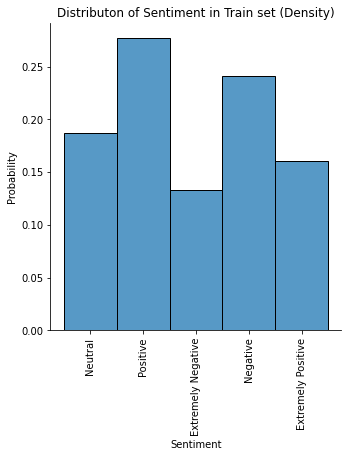

In [9]:
# Distribution of Sentiment in train set and test set (Proportion)
sns.displot(Corona_train,x="Sentiment",stat="probability")
plt.xticks(rotation=90)
plt.title("Distributon of Sentiment in Train set (Density)")

Text(0.5, 1.0, 'Distributon of Sentiment in Test set (Density)')

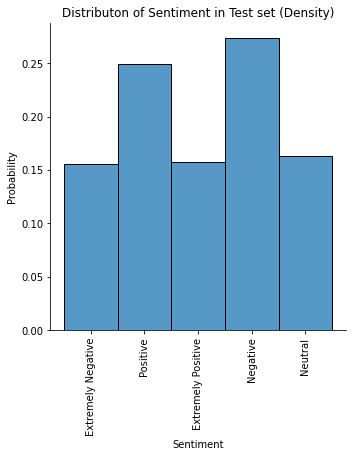

In [10]:
sns.displot(Corona_test,x="Sentiment",stat="probability")
plt.xticks(rotation=90)
plt.title("Distributon of Sentiment in Test set (Density)")

Text(0.5, 1.0, 'Distribution Sentiment over Time in Train set')

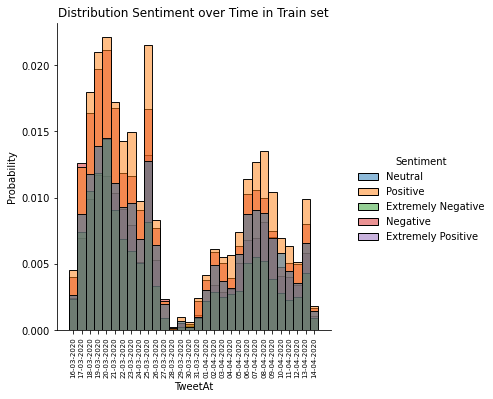

In [11]:
# Distribution Sentiment over Time in Train set
sns.displot(Corona_train,x="TweetAt",hue="Sentiment",stat="probability")
plt.xticks(rotation=90)
plt.tick_params(axis='x',labelsize=7)
plt.title("Distribution Sentiment over Time in Train set")

Text(0.5, 1.0, 'Distribution Sentiment over Time in Test set')

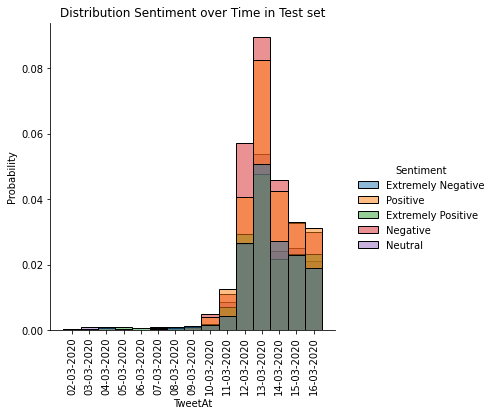

In [12]:
# Distribution Sentiment over Time in Test set
sns.displot(Corona_test,x="TweetAt",hue="Sentiment",stat="probability")
plt.xticks(rotation=90)
plt.title("Distribution Sentiment over Time in Test set")

### Quantitative element to describe to the dataset

In [13]:
Corona_train['Sentiment'].value_counts()/len(Corona_train['Sentiment'])

Positive              0.277523
Negative              0.240955
Neutral               0.187404
Extremely Positive    0.160945
Extremely Negative    0.133173
Name: Sentiment, dtype: float64

In [14]:
Corona_test['Sentiment'].value_counts()/len(Corona_test['Sentiment'])

Negative              0.274092
Positive              0.249342
Neutral               0.162981
Extremely Positive    0.157715
Extremely Negative    0.155872
Name: Sentiment, dtype: float64

In the training set, the positive tweets account for the most (27.8%), while in the test set, the negative tweets account for the largest proportion (27.4%). 

According to the information above and the plot of sentiment evolution over time in previous section, we can see that the collection times of tweets in test set are earlier than those in train set. There are more negative sentiments in test set (earlier tweets) than in train set (later tweets), and there are more positive sentiments in train set (later tweets) than in test set (earlier tweets). People became more positive as time went by.

### Clean the dataset with nltk

In [15]:
Corona_train_clean=Corona_train.copy()
Corona_test_clean=Corona_test.copy()

TRAINING SET

In [16]:
Corona_train_clean["OriginalTweet"]

0        @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1        advice Talk to your neighbours family to excha...
2        Coronavirus Australia: Woolworths to give elde...
3        My food stock is not the only one which is emp...
4        Me, ready to go at supermarket during the #COV...
                               ...                        
41152    Airline pilots offering to stock supermarket s...
41153    Response to complaint not provided citing COVI...
41154    You know itÂs getting tough when @KameronWild...
41155    Is it wrong that the smell of hand sanitizer i...
41156    @TartiiCat Well new/used Rift S are going for ...
Name: OriginalTweet, Length: 41157, dtype: object

In [17]:
# Remove the urls and @
Corona_train_clean["OriginalTweet"] = Corona_train_clean["OriginalTweet"].str.replace(r'http\S+', '', regex = True)
Corona_train_clean["OriginalTweet"] = Corona_train_clean["OriginalTweet"].str.replace(r'@\S+', '', regex = True)
Corona_train_clean["OriginalTweet"].head()

0                                            and  and 
1    advice Talk to your neighbours family to excha...
2    Coronavirus Australia: Woolworths to give elde...
3    My food stock is not the only one which is emp...
4    Me, ready to go at supermarket during the #COV...
Name: OriginalTweet, dtype: object

In [18]:
# Remove other punctuations and stop words
stop_words = stopwords.words("english")
stop_words.append('amp')
tokenizer = nltk.RegexpTokenizer(r"\w+")
for i in range(0,len(Corona_train_clean["OriginalTweet"])):
  Corona_train_clean["OriginalTweet"][i] = tokenizer.tokenize(Corona_train_clean["OriginalTweet"][i])
  Corona_train_clean["OriginalTweet"][i]=" ".join([word for word in Corona_train_clean["OriginalTweet"][i] if not word.lower() in stop_words])
  Corona_train_clean["OriginalTweet"][i] = Corona_train_clean["OriginalTweet"][i].lower()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [19]:
Corona_train_clean["OriginalTweet"].head()

0                                                     
1    advice talk neighbours family exchange phone n...
2    coronavirus australia woolworths give elderly ...
3    food stock one empty please panic enough food ...
4    ready go supermarket covid19 outbreak paranoid...
Name: OriginalTweet, dtype: object

TEST SET

In [20]:
# Test set
# Remove the urls and @
Corona_test_clean["OriginalTweet"] = Corona_test_clean["OriginalTweet"].str.replace(r'http\S+', '', regex = True)
Corona_test_clean["OriginalTweet"] = Corona_test_clean["OriginalTweet"].str.replace(r'@\S+', '', regex = True)
Corona_test_clean["OriginalTweet"].head()

0    TRENDING: New Yorkers encounter empty supermar...
1    When I couldn't find hand sanitizer at Fred Me...
2    Find out how you can protect yourself and love...
3    #Panic buying hits #NewYork City as anxious sh...
4    #toiletpaper #dunnypaper #coronavirus #coronav...
Name: OriginalTweet, dtype: object

In [21]:
# Remove other punctuations and stop words
tokenizer = nltk.RegexpTokenizer(r"\w+")
for i in range(0,len(Corona_test_clean["OriginalTweet"])):
  Corona_test_clean["OriginalTweet"][i] = tokenizer.tokenize(Corona_test_clean["OriginalTweet"][i])
  Corona_test_clean["OriginalTweet"][i]=" ".join([word for word in Corona_test_clean["OriginalTweet"][i] if not word.lower() in stop_words])
  Corona_test_clean["OriginalTweet"][i] = Corona_test_clean["OriginalTweet"][i].lower()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
Corona_test_clean["OriginalTweet"].head()

0    trending new yorkers encounter empty supermark...
1    find hand sanitizer fred meyer turned amazon 1...
2                  find protect loved ones coronavirus
3    panic buying hits newyork city anxious shopper...
4    toiletpaper dunnypaper coronavirus coronavirus...
Name: OriginalTweet, dtype: object

###Words cloud

In [23]:
# Create the corpus 'wctext' to do the word cloud
wctext_train=' '.join(Corona_train_clean["OriginalTweet"])
wctext_train

' advice talk neighbours family exchange phone numbers create contact list phone numbers neighbours schools employer chemist gp set online shopping accounts poss adequate supplies regular meds order coronavirus australia woolworths give elderly disabled dedicated shopping hours amid covid 19 outbreak food stock one empty please panic enough food everyone take need stay calm stay safe covid19france covid_19 covid19 coronavirus confinement confinementotal confinementgeneral ready go supermarket covid19 outbreak paranoid food stock litteraly empty coronavirus serious thing please panic causes shortage coronavirusfrance restezchezvous stayathome confinement news regionâ first confirmed covid 19 case came sullivan county last week people flocked area stores purchase cleaning supplies hand sanitizer food toilet paper goods reports cashier grocery store sharing insights covid_19 prove credibility commented civics class know talking supermarket today buy toilet paper rebel toiletpapercrisis co

In [24]:
# Create the corpus 'wctext' to do the word cloud
wctext_test=' '.join(Corona_test_clean["OriginalTweet"])
wctext_test

'trending new yorkers encounter empty supermarket shelves pictured wegmans brooklyn sold online grocers foodkick maxdelivery coronavirus fearing shoppers stock find hand sanitizer fred meyer turned amazon 114 97 2 pack purell check coronavirus concerns driving prices find protect loved ones coronavirus panic buying hits newyork city anxious shoppers stock food medical supplies healthcare worker 30s becomes bigapple 1st confirmed coronavirus patient bloomberg staged event qanon qanon2018 qanon2020 election2020 cdc toiletpaper dunnypaper coronavirus coronavirusaustralia coronavirusupdate covid_19 9news corvid19 7newsmelb dunnypapergate costco one week everyone buying baby milk powder next everyone buying toilet paper remember last time paid 2 99 gallon regular gas los angeles prices pump going look coronavirus impacting prices 4pm voting age coronavirus hand sanitizer supertuesday canâ stop covid19 without protecting healthworkers prices surgical masks increased six fold n95 respirators 

In [25]:
# Words Cloud
Tweet_wordcloud_train=WordCloud(background_color="white",width=1000,height=1000,margin=2).generate(wctext_train)
Tweet_wordcloud_test=WordCloud(background_color="white",width=1000,height=1000,margin=2).generate(wctext_test)

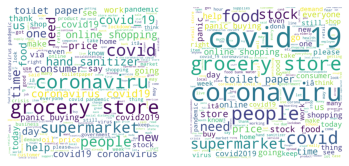

In [26]:
plt.subplot(1,2,1)
plt.imshow(Tweet_wordcloud_train)
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(Tweet_wordcloud_test)
plt.axis("off")

plt.show()

Coronaviru seems to be the most frequency word. We want to see the details about the generation method for this wordcloud. So we write the code below. Here, we only look at the training data.

In [27]:
# create a dictionary of word frequencies of the word cloud we build
wctext_dictionary = Tweet_wordcloud_train.process_text(wctext_train)

In [28]:
# sort the dictionary
wctext_freq={k: v for k, v in sorted(wctext_dictionary.items(),reverse=True, key=lambda item: item[1])}

In [29]:
rel_freq=Tweet_wordcloud_train.words_

In [30]:
#print results
print(list(wctext_freq.items())[:5])
print(list(rel_freq.items())[:5])

[('grocery store', 5132), ('coronaviru', 5025), ('covid', 3834), ('supermarket', 3119), ('people', 2798)]
[('grocery store', 1.0), ('coronaviru', 0.9791504286827748), ('covid', 0.7470771628994544), ('supermarket', 0.607755261106781), ('people', 0.5452065471551052)]


Looking at the results above, we understand that if we generate word cloud from text using the .generate(), some words like 'grocery' and 'store' are put into together as a word group, because python thinks grocery store does have a real meaning from the text level. However, if we want to generate wordcloud according to the the real frequency of each word, we have to use the .generate_from_frequencies(). We also put the alternative method to generate the word cloud below.

In [31]:
import collections
# Generate words by frequency
wctextlist_train = wctext_train.split()
wctextlist_test = wctext_test.split()
words_count_train = collections.Counter(wctextlist_train)
words_count_test = collections.Counter(wctextlist_test)

In [32]:
wc_train = WordCloud(background_color="white",width=1000,height=1000,margin=2).generate_from_frequencies(words_count_train)

In [33]:
wc_test = WordCloud(background_color="white",width=1000,height=1000,margin=2).generate_from_frequencies(words_count_test)

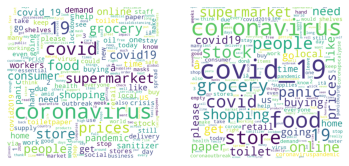

In [34]:
plt.subplot(1,2,1)
plt.imshow(wc_train)
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(wc_test)
plt.axis("off")

plt.show()

In this alternative method, the most frequency word seems to be coronavirus instead of coronaviru before. What's more, the grocery and store are considered as two seperated words appearing in this word cloud.

### Most frequent words according to different sentiment

In [35]:
list_sentiment=['Positive','Negative','Neutral','Extremely Positive','Extremely Negative']

In [36]:
for sentiment in list_sentiment:
  text_tweet=' '.join(Corona_train_clean[Corona_train_clean["Sentiment"]==sentiment]["OriginalTweet"])
  split_it = text_tweet.split()
  counter = Counter(split_it).most_common(6)
  print(sentiment,counter)

Positive [('coronavirus', 4880), ('19', 3479), ('covid', 3398), ('store', 2063), ('prices', 2033), ('grocery', 1941)]
Negative [('coronavirus', 4354), ('19', 3112), ('covid', 3007), ('prices', 2376), ('food', 2064), ('supermarket', 1748)]
Neutral [('coronavirus', 3822), ('19', 2180), ('covid', 2155), ('supermarket', 1351), ('store', 1342), ('prices', 1229)]
Extremely Positive [('coronavirus', 2668), ('19', 2040), ('covid', 1913), ('store', 1284), ('supermarket', 1105), ('grocery', 1083)]
Extremely Negative [('coronavirus', 2429), ('19', 1785), ('covid', 1716), ('food', 1589), ('prices', 1357), ('people', 1236)]


In [37]:
positiveFD = nltk.FreqDist(word for text in Corona_train_clean[Corona_train_clean["Sentiment"] == 'Positive']["OriginalTweet"] for word in text.split())

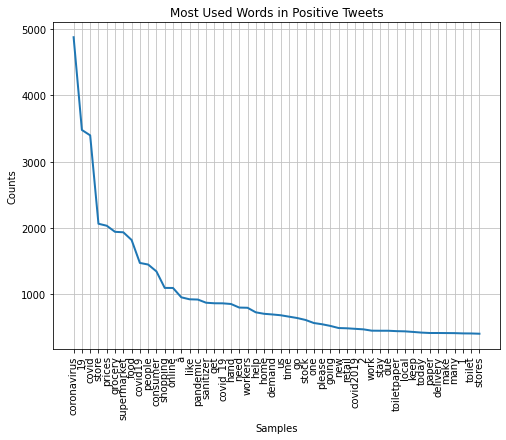

In [38]:
## Most Used Words in Positive Tweets
plt.subplots(figsize=(8,6))
plt.title("Most Used Words in Positive Tweets")
positiveFD.plot(50)
plt.show()

In [39]:
negativeFD = nltk.FreqDist(word for text in Corona_train_clean[Corona_train_clean["Sentiment"] == 'Negative']["OriginalTweet"] for word in text.split())

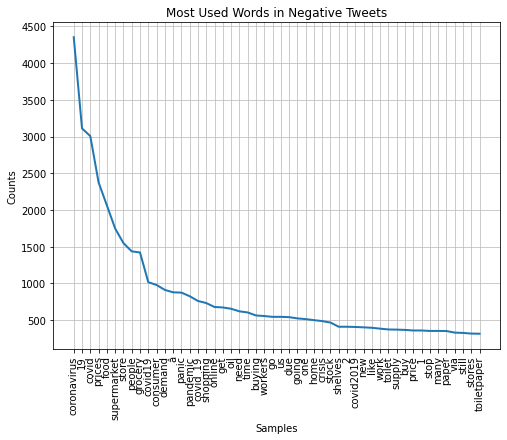

In [40]:
## Most Used Words in Negative Tweets
plt.subplots(figsize=(8,6))
plt.title("Most Used Words in Negative Tweets")
negativeFD.plot(50)
plt.show()

We can see from the results above that words related to coronavirus like 'covid' and '19' appear most in each sentiment. Apart from that, we can see for example in sentiment positive, 'grocery', 'stores' and 'prices' appear most and for sentiment negative, 'food', 'prices', and 'supermarket' seem appear most.

### Tf-idf

As we saw before, the most frequence word of all the sentiment groups contain the "coronavirus","19","covid", however, these words is just the topics of these tweet since we exctracted the tweet about coronavirus at the very begining. They can not help us to predict the sentiment expressed by the tweets. To have a cleaner corpus to feed the models, we create a corona_train_clean2 and corona_test_clean2 without these words. We repeate the text-cleaning process on these two datasets again.

In [41]:
Corona_train_clean2=Corona_train.copy()
Corona_test_clean2=Corona_test.copy()

Training set

In [42]:
# Remove the urls and @
Corona_train_clean2["OriginalTweet"] = Corona_train_clean2["OriginalTweet"].str.replace(r'http\S+', '', regex = True)
Corona_train_clean2["OriginalTweet"] = Corona_train_clean2["OriginalTweet"].str.replace(r'@\S+', '', regex = True)
Corona_train_clean2["OriginalTweet"].head()

0                                            and  and 
1    advice Talk to your neighbours family to excha...
2    Coronavirus Australia: Woolworths to give elde...
3    My food stock is not the only one which is emp...
4    Me, ready to go at supermarket during the #COV...
Name: OriginalTweet, dtype: object

In [43]:
# Remove other punctuations and stop words
newStopWords = ['19',"coronavirus","covid"]
stop_words.extend(newStopWords)
tokenizer = nltk.RegexpTokenizer(r"\w+")
for i in range(0,len(Corona_train_clean2["OriginalTweet"])):
  Corona_train_clean2["OriginalTweet"][i] = tokenizer.tokenize(Corona_train_clean2["OriginalTweet"][i])
  Corona_train_clean2["OriginalTweet"][i]=" ".join([word for word in Corona_train_clean2["OriginalTweet"][i] if not word.lower() in stop_words])
  Corona_train_clean2["OriginalTweet"][i] = Corona_train_clean2["OriginalTweet"][i].lower()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Test set

In [44]:
# Remove the urls and @ in test set
Corona_test_clean2["OriginalTweet"] = Corona_test_clean2["OriginalTweet"].str.replace(r'http\S+', '', regex = True)
Corona_test_clean2["OriginalTweet"] = Corona_test_clean2["OriginalTweet"].str.replace(r'@\S+', '', regex = True)
Corona_test_clean2["OriginalTweet"].head()

0    TRENDING: New Yorkers encounter empty supermar...
1    When I couldn't find hand sanitizer at Fred Me...
2    Find out how you can protect yourself and love...
3    #Panic buying hits #NewYork City as anxious sh...
4    #toiletpaper #dunnypaper #coronavirus #coronav...
Name: OriginalTweet, dtype: object

In [45]:
# Remove other punctuations and stop words in test set
newStopWords = ['19',"coronavirus","covid"]
stop_words.extend(newStopWords)
tokenizer = nltk.RegexpTokenizer(r"\w+")
for i in range(0,len(Corona_test_clean2["OriginalTweet"])):
  Corona_test_clean2["OriginalTweet"][i] = tokenizer.tokenize(Corona_test_clean2["OriginalTweet"][i])
  Corona_test_clean2["OriginalTweet"][i]=" ".join([word for word in Corona_test_clean2["OriginalTweet"][i] if not word.lower() in stop_words])
  Corona_test_clean2["OriginalTweet"][i] = Corona_test_clean2["OriginalTweet"][i].lower()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [46]:
x_train = Corona_train_clean2["OriginalTweet"]
y_train = Corona_train_clean2["Sentiment"]
x_test = Corona_test_clean2["OriginalTweet"]
y_test = Corona_test_clean2["Sentiment"]

In [47]:
#Use tf-idf model to transform the terms into vectors which are filled with related weights.
number_of_dimensions = 1000

tfidf_vectorizer = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1, 2),
    max_features=number_of_dimensions,
    max_df=0.90,
    min_df=0.05)


tfidf_vectorizer.fit(x_train)

x_train_features = tfidf_vectorizer.transform(x_train).toarray()
x_test_features = tfidf_vectorizer.transform(x_test).toarray()

In [48]:
x_train_features.shape

(41157, 24)

In [49]:
x_train_features[50]

array([0.        , 0.        , 0.        , 0.        , 0.60567186,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.79571452,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

##Clustering and topic identification

### Using Kmeans to cluster the corpus

Silouette method which helps us to determine the number of clusters in k means.

In [50]:
for i in [3,4,5,6,7]:
  km = KMeans(n_clusters=i)
  km.fit(x_train_features)
  clusters = km.labels_.tolist()
  score = silhouette_score(x_train_features,km.labels_,metric='euclidean')
  print('silouette score:' ,i,score)

silouette score: 3 0.171242887057489
silouette score: 4 0.19440501618751957
silouette score: 5 0.24479274149686428
silouette score: 6 0.2519137617570236
silouette score: 7 0.2633708479297651


According to the results above, the silouette score increased slower since 5 clusters compared to the increase from 3 to 4 and 4 to 5 

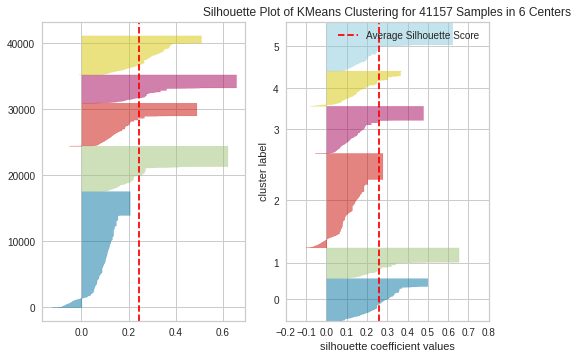

In [51]:
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.datasets import load_nfl

# Instantiate the clustering model and visualizer
plt.subplot(1,2,1)
model_km = KMeans(5, random_state=42)
visualizer = SilhouetteVisualizer(model_km, colors='yellowbrick')
visualizer.fit(x_train_features) 

plt.subplot(1,2,2)
model_km = KMeans(6, random_state=42)
visualizer = SilhouetteVisualizer(model_km, colors='yellowbrick')
visualizer.fit(x_train_features) 

visualizer.show()  

According to the graphs above, each sillouette score for 6 clusters exceed the average sillouette score and the thickness of each cluster is more or less equal compared to the 5 clusters. We think that 6 clusters may be better than 5 clusters. And then, we use Elbow method to ensure our proposition.

In [52]:
# Elbow method (an elbow point will be the choice)
distortions = []
K = range(3,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(x_train_features)
    distortions.append(kmeanModel.inertia_)

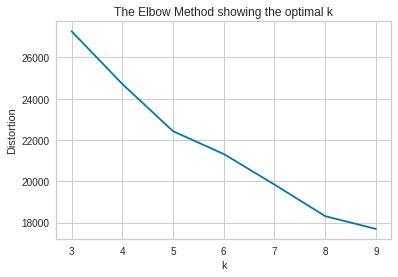

In [53]:
plt.figure(figsize=(6,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

There is a little twist when k = 6, so we decide to choose 6 as the cluster number

In [54]:
num_clusters = 6

km = KMeans(n_clusters=num_clusters)

%time km.fit(x_train_features)

cluster = km.labels_.tolist()

CPU times: user 1.83 s, sys: 773 ms, total: 2.6 s
Wall time: 1.39 s


In [55]:
tweet = {'User name': Corona_train_clean2["UserName"], 'Original Tweet': Corona_train_clean2["OriginalTweet"], 'cluster': cluster, 'Sentiment': Corona_train_clean2["Sentiment"] }
tweet_frame = pd.DataFrame(tweet, columns = ['User name', 'Original Tweet', 'cluster', 'Sentiment'])

In [56]:
tweet_frame.head()

User name  ...           Sentiment
0       3799  ...             Neutral
1       3800  ...            Positive
2       3801  ...            Positive
3       3802  ...            Positive
4       3803  ...  Extremely Negative

[5 rows x 4 columns]

In [57]:
tweet_frame['cluster'].value_counts()

3    14790
1     6854
2     6497
0     5880
4     4247
5     2889
Name: cluster, dtype: int64

In [58]:
list_cluster = [i for i in range(6)]

In [59]:
for cluster in list_cluster:
  cluster_tweet=''.join(tweet_frame[tweet_frame["cluster"]==cluster]["Original Tweet"])
  split_it = cluster_tweet.split()
  counter = Counter(split_it).most_common(10)
  print(cluster,counter)

0 [('store', 5922), ('grocery', 4941), ('workers', 1059), ('people', 855), ('go', 599), ('retail', 576), ('get', 537), ('like', 480), ('employees', 471), ('covid_19', 445)]
1 [('prices', 6801), ('oil', 1347), ('pandemic', 511), ('people', 500), ('price', 487), ('due', 485), ('low', 450), ('â', 441), ('gas', 439), ('market', 423)]
2 [('supermarket', 5988), ('people', 1180), ('shelves', 643), ('workers', 629), ('get', 576), ('go', 562), ('staff', 553), ('like', 482), ('covid_19', 466), ('local', 447)]
3 [('food', 5214), ('people', 2047), ('sanitizer', 2040), ('panic', 1815), ('covid19', 1582), ('hand', 1524), ('demand', 1379), ('stock', 1328), ('need', 1253), ('toiletpaper', 1178)]
4 [('consumer', 4018), ('pandemic', 388), ('covid19', 382), ('behavior', 318), ('business', 309), ('impact', 261), ('protection', 256), ('â', 256), ('new', 255), ('crisis', 239)]
5 [('online', 2675), ('shopping', 2556), ('people', 327), ('grocery', 298), ('delivery', 294), ('home', 282), ('covid19', 226), ('st

Profile of texts

0: People go to supermarket to buy the toilet paper and hand sanitizer because of covid 19

1: Cluster 1 groups the tweets which talk about the oil price during the pandemic

2: Workers' working situation in the retail industry

3: Tweets about people's panic towards the lack of food stock

4: People do online shopping and get deliveries at home due to the covid19.

5: Pandemic has an impact on consumers' and business' behavior

###NMF

In [60]:
x_train

0                                                         
1        advice talk neighbours family exchange phone n...
2        australia woolworths give elderly disabled ded...
3        food stock one empty please panic enough food ...
4        ready go supermarket covid19 outbreak paranoid...
                               ...                        
41152    airline pilots offering stock supermarket shel...
41153    response complaint provided citing related del...
41154    know itâ getting tough rationing toilet paper ...
41155     wrong smell hand sanitizer starting turn covid19
41156    well new used rift going 700 00 amazon rn alth...
Name: OriginalTweet, Length: 41157, dtype: object

In [61]:
# Create an NMF model
# the 6 components will be the topics
model_nmf = NMF(n_components=6, random_state=3)
 
# Fit the model to TF-IDF
model_nmf.fit(x_train_features)
 
# Transform the TF-IDF: nmf_features
nmf_features = model_nmf.transform(x_train_features)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


For the nmf decomposition, we have V=W*H. This decomposition allows us to reduce the dimension of input matrix and numerize the text inputs in order to do further analysis in prediction models.

In [62]:
#V: Input(Visible matrix): Tweet * terms (41157*24)
x_train_features.shape

(41157, 24)

In [63]:
#W: Feature set(Weights): Tweet * topics (41157*6)
nmf_features.shape

(41157, 6)

In [64]:
#H: Coefficients(Hidden variables): topics * terms (6*24)
model_nmf.components_.shape

(6, 24)

In [65]:
#Put each term as the colum name for matrix H
components_ = pd.DataFrame(model_nmf.components_, columns=tfidf_vectorizer.get_feature_names())
components_

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


consumer   covid19  covid_19  ...      time        us   workers
0  0.000000  0.179638  0.440803  ...  0.284131  0.338000  0.012373
1  0.000000  0.081643  0.711946  ...  0.317239  0.219109  0.938565
2  0.000000  0.030357  0.649592  ...  0.228256  0.125688  0.433962
3  7.151442  0.230792  0.079679  ...  0.199577  0.287298  0.026815
4  0.000000  0.000000  0.185941  ...  0.230304  0.298452  0.113639
5  0.000000  4.231341  0.290729  ...  0.292930  0.302264  0.007517

[6 rows x 24 columns]

In [66]:
#To see the 6 most frequent words in each topic
for topic in range(components_.shape[0]):
    tmp = components_.iloc[topic]
    print(f'For topic {topic+1} the words with the highest value are:')
    print(tmp.nlargest(10))
    print('\n')

For topic 1 the words with the highest value are:
prices      9.304103
pandemic    0.618247
covid_19    0.440803
people      0.353826
us          0.338000
time        0.284131
demand      0.275749
like        0.180024
covid19     0.179638
get         0.151042
Name: 0, dtype: float64


For topic 2 the words with the highest value are:
store            5.174857
grocery          4.568422
grocery store    4.190452
workers          0.938565
covid_19         0.711946
people           0.663400
go               0.568626
get              0.486914
like             0.465450
time             0.317239
Name: 1, dtype: float64


For topic 3 the words with the highest value are:
supermarket    6.573033
people         0.893926
covid_19       0.649592
workers        0.433962
get            0.387215
go             0.383315
like           0.339263
home           0.239486
time           0.228256
need           0.224841
Name: 2, dtype: float64


For topic 4 the words with the highest value are:
consumer    

In [67]:
# Parametrization of NMF
Feature_train = pd.DataFrame(nmf_features,columns=[i for i in range(6)])
Feature_train

0         1         2         3         4         5
0      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
1      0.000000  0.000000  0.000000  0.000000  0.000000  0.108141
2      0.000000  0.000000  0.000000  0.000000  0.000000  0.075480
3      0.000429  0.001567  0.002056  0.000000  0.110014  0.033661
4      0.000000  0.000000  0.054697  0.000000  0.073157  0.038180
...         ...       ...       ...       ...       ...       ...
41152  0.000000  0.000000  0.145386  0.000000  0.000000  0.000000
41153  0.000165  0.005469  0.005546  0.087000  0.001312  0.000000
41154  0.003512  0.002665  0.002062  0.005121  0.006077  0.006174
41155  0.000000  0.000000  0.000000  0.000000  0.000000  0.086751
41156  0.106126  0.000000  0.000000  0.000000  0.000000  0.000000

[41157 rows x 6 columns]

### Analogy between Soft-clustering NMF

In Soft-clustering, each unit in the data set has probability to be in each cluster. NMF has a similar philosophy that each unit has probability to be allocated to more than one topic.

###Sentiment according to clusters

In [68]:
tweet_frame.drop(columns=['User name']).groupby(["cluster","Sentiment"]).count()

Original Tweet
cluster Sentiment                         
0       Extremely Negative             552
        Extremely Positive            1060
        Negative                      1323
        Neutral                       1185
        Positive                      1760
1       Extremely Negative            1138
        Extremely Positive             801
        Negative                      2059
        Neutral                       1112
        Positive                      1744
2       Extremely Negative             832
        Extremely Positive            1006
        Negative                      1604
        Neutral                       1271
        Positive                      1784
3       Extremely Negative            2279
        Extremely Positive            2479
        Negative                      3457
        Neutral                       2556
        Positive                      4019
4       Extremely Negative             473
        Extremely Positive             698
        Negative                       912
        Neutral                        952
        Positive                      1212
5       Extremely Negative             207
        Extremely Positive             580
        Negative                       562
        Neutral                        637
        Positive                       903

Sentiment according to the clusters/profiles

0: Concerning the tweets that talk about the purchase of cleaning product, more people seem to be positive towards the covid situation.

1: Concenrning the oil price, most people are negative

2: People are quite optimistic about the working situation in retail industry

3: People are worried about the food stock in the supermarket

4: People who talk about online shopping show their positive attitude

5: People are positive to the covid impact on consumers' and business' behavior. 

#  Sentiment analysis and inference

In this section, we will use several algorithms to predict the sentiments. We mainly used classification methods because it helps to divide dataset into classes by finding a function based on different parameter. In other words, classification algorithms find mapping function to map input (x) to the discrete output (y). We also tried regression in LSTM. We set the class with biggest predicted probability as the predicted class for each tweet.

In [69]:
## We use the parametrization of NMF to feed our models
## Let's get the parametrization for test set first
nmf_features_test = model_nmf.transform(x_test_features)
 
Feature_test = pd.DataFrame(nmf_features_test)



*   Training set: Feature_train, y_train

*   Test set: Feature_test, y_test


In [70]:
y_train.value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

Encoding sentiment

In [71]:
encode_nums = {"Extremely Negative": 0, "Negative": 1,"Neutral": 2, "Positive": 3,"Extremely Positive": 4}

In [72]:
y_train = y_train.replace(encode_nums)
y_train.head()

0    2
1    3
2    3
3    3
4    0
Name: Sentiment, dtype: int64

In [73]:
y_test = y_test.replace(encode_nums)
y_test.head()

0    0
1    3
2    4
3    1
4    2
Name: Sentiment, dtype: int64

## Penalized Multinominal Logistic Regression (Ridge)

In [74]:
from sklearn.linear_model import LogisticRegression

In [75]:
# Grid of penalty parameters
param = [{"C": [0.5, 1, 5, 10, 12, 15, 30]}] # dictionary of the values of C used for GridSearchCV


# 1. Define a model (logistic regression)
# 2. Use the penalty="l2"
# 3. Use GridSearchCV to obtain automatically the best regularization parameter 

logitR=GridSearchCV(LogisticRegression(multi_class='multinomial', penalty='l2',solver='newton-cg',random_state=111),param,cv=5)
logitRidge=logitR.fit(Feature_train, y_train)

In [76]:
# Computation of the loss
print("Best learning rate = %f, Best parameter  = %s" %
      (1.-logitRidge.best_score_,logitRidge.best_params_))

Best learning rate = 0.708239, Best parameter  = {'C': 0.5}


In [77]:
# Prediction with the model
yChap = logitRidge.predict(Feature_test)
# TODO:  compute the  confusion matrix with the help of pd.crosstab
table=pd.crosstab(yChap,y_test)
print(table)

# Error on the test set
print("Test error - Logistic regression  Ridge = %f" % (1-logitRidge.score(Feature_test, y_test)))
print('accuracy: {}'.format(round(accuracy_score(y_test,yChap), 4)))

Sentiment    0    1    2    3    4
row_0                             
1          268  387  147  275  162
3          324  654  472  672  437
Test error - Logistic regression  Ridge = 0.721169
accuracy: 0.2788


In [78]:
confusion_matrix(yChap,y_test)

array([[  0,   0,   0,   0,   0],
       [268, 387, 147, 275, 162],
       [  0,   0,   0,   0,   0],
       [324, 654, 472, 672, 437],
       [  0,   0,   0,   0,   0]])

The result of Multinominal Logistic Regression is not good since it can only give two classes among five after the prediction and the accuracy is 27.9%.

The result of NMF parametrization performs bad, we infer that this might come from the over-elimination of information from the original dataset, so we try to feed the model with the TF-IDF matrix of training set directly which contians more information.

In [79]:
#Use tf-idf model to transform the terms into vectors which are filled with related weights.
number_of_dimensions = 1000

tfidf_vectorizer2 = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1, 2),
    max_features=number_of_dimensions,
    max_df=0.9,
    min_df=0.01)


tfidf_vectorizer2.fit(x_train)

x_train_features2 = tfidf_vectorizer2.transform(x_train).toarray()
x_test_features2 = tfidf_vectorizer2.transform(x_test).toarray()

In [80]:
x_train_features2.shape

(41157, 255)

In [81]:
x_train_features2

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [82]:
# Grid of penalty parameters
param = [{"C": [1, 5, 10, 15, 30]}] # dictionary of the values of C used for GridSearchCV


# 1. Define a model (logistic regression)
# 2. Use the penalty="l2"
# 3. Use GridSearchCV to obtain automatically the best regularization parameter 

logitR=GridSearchCV(LogisticRegression(multi_class='multinomial', penalty='l2',solver='newton-cg',random_state=111),param,cv=5)
logitRidge=logitR.fit(x_train_features2, y_train)

In [83]:
# Computation of the loss
print("Best learning rate = %f, Best parameter  = %s" %
      (1.-logitRidge.best_score_,logitRidge.best_params_))

Best learning rate = 0.562335, Best parameter  = {'C': 30}


In [84]:
# Prediction with the model
yChap = logitRidge.predict(x_test_features2)
# TODO:  compute the  confusion matrix with the help of pd.crosstab
table=pd.crosstab(yChap,y_test)
print(table)

# Evaluation on the test set
print("Test error - Logistic regression  Ridge = %f" % (1-logitRidge.score(x_test_features2, y_test)))
print('accuracy: {}'.format(round(accuracy_score(y_test, yChap), 4)))

Sentiment    0    1    2    3    4
row_0                             
0          182  111   10   38   10
1          208  379  116  180   58
2           80  235  377  197   53
3          109  269  110  402  221
4           13   47    6  130  257
Test error - Logistic regression  Ridge = 0.579516
accuracy: 0.4205


The accuracy of logistic regression (ridge) with TF-IDF matrix is 42.1% which looks better than the NMF Parametrization. To be noted that this time we change min_df in the TfidfVectorizer() from 0.05 to 0.01 to include more terms.We will use the TF-IDF to feed our following model

## Random Forest

In [85]:
from sklearn.ensemble import RandomForestClassifier

In [86]:
# Optimization of max_features
param=[{"max_depth":list(range(7,10,1)),"n_estimators":[300,500]}]

rf= GridSearchCV(RandomForestClassifier(max_features='sqrt'),param,cv=5,n_jobs=-1)
rfOpt=rf.fit(x_train_features2, y_train)
# optimal parameter 
print("Best score = %f, Best parameter = %s" % (1. - rfOpt.best_score_,rfOpt.best_params_))

Best score = 0.635226, Best parameter = {'max_depth': 9, 'n_estimators': 300}


In [87]:
# Prediction on the test set
yChap = rfOpt.predict(x_test_features2)
# Confusion matrix
table=pd.crosstab(yChap,y_test)
print(table)

# Prediction error on the test set
print("Prediction error with random forest = %f" % (1-rfOpt.score(x_test_features2,y_test)))

Sentiment    0    1    2    3    4
row_0                             
0          102   60    5   22    6
1          187  245   27   77   37
2            3   18   34   12    6
3          295  706  551  801  424
4            5   12    2   35  126
Prediction error with random forest = 0.655608


In [88]:
print(confusion_matrix(yChap,y_test))
print('accuracy: {}'.format(round(accuracy_score(y_test, yChap), 4)))

[[102  60   5  22   6]
 [187 245  27  77  37]
 [  3  18  34  12   6]
 [295 706 551 801 424]
 [  5  12   2  35 126]]
accuracy: 0.3444


The Random Forest seems to perform a little worse than the Logistic regression with an accuracy of 35%. 

Now, we will change our path to neural net work.

## Deep Neural Nework

###Multilayer perceptrons

In [89]:
#encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
#convert integers to dummy variables
dummy_y = np_utils.to_categorical(encoded_Y)

In [90]:
dummy_y

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [91]:
y_train_dum = to_categorical(y_train, 5)
y_train_dum

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [92]:
y_test_dum = to_categorical(y_test, 5)
y_test_dum

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [93]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
import numpy

number_of_dimensions = 255
neurons1=list(range(120,160,10))
neurons2=list(range(50,80,10))
param_grid=dict(neurons1=neurons1,neurons2=neurons2)

def NN_model(neurons1,neurons2):
   model = Sequential()

  # Adds a densely-connected layer with 128 units to the model
   model.add(Dense(neurons1, input_shape=(number_of_dimensions,)))

  # Adds a densely-connected layer with 64 units to the model
   model.add(Dense(neurons2))

  # Add a softmax layer with 5 output units
   model.add(Dense(5,activation='softmax'))

   model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])
   
   return model
  
seed = 8
numpy.random.seed(seed)

model = KerasClassifier(build_fn=NN_model,epochs=20,batch_size=1024)

model_grid = GridSearchCV(estimator=model,param_grid=param_grid,n_jobs=-1,cv=3)

grid_result = model_grid.fit(x_train_features2,y_train_dum,validation_split=0.1)

print("Best: %f using %s" % (grid_result.best_score_,grid_result.best_params_))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/20
37/37 [==============================] - 2s 19ms/step - loss: 1.5055 - accuracy: 0.3213 - val_loss: 1.4148 - val_accuracy: 0.3875
Epoch 2/20
37/37 [==============================] - 0s 12ms/step - loss: 1.3564 - accuracy: 0.4107 - val_loss: 1.3265 - val_accuracy: 0.4366
Epoch 3/20
37/37 [==============================] - 0s 13ms/step - loss: 1.3075 - accuracy: 0.4399 - val_loss: 1.3069 - val_accuracy: 0.4495
Epoch 4/20
37/37 [==============================] - 0s 11ms/step - loss: 1.2963 - accuracy: 0.4455 - val_loss: 1.3026 - val_accuracy: 0.4534
Epoch 5/20
37/37 [==============================] - 0s 13ms/step - loss: 1.2925 - accuracy: 0.4491 - val_loss: 1.2994 - val_accuracy: 0.4543
Epoch 6/20
37/37 [==============================] - 0s 11ms/step - loss: 1.2906 - accuracy: 0.4524 - val_loss: 1.3000 - val_accuracy: 0.4558
Epoch 7/20
37/37 [==============================] - 0s 12ms/step - loss: 1.2897 - accuracy: 0.4508 - val_loss: 1.2973 - val_accuracy: 0.4524
Epoch 8/20
37

In [94]:
y_pred_nn = model_grid.predict(x_test_features2)

In [95]:
y_pred_nn.shape

(3798,)

In [96]:
# Confusion matrix
table=pd.crosstab(y_pred_nn,y_test)
print(table)

# Prediction error on the test set
print("Prediction error with neural network = %f" % (1-model_grid.score(x_test_features2,y_test)))

Sentiment    0    1    2    3    4
row_0                             
0          185  111   12   42   11
1          206  386  131  176   62
2           80  238  376  197   50
3          109  261   96  414  233
4           12   45    4  118  243
4/4 [==============================] - 0s 6ms/step - loss: 1.3277 - accuracy: 0.4223
Prediction error with neural network = 0.577672


In [97]:
# Accuracy on the test set
print('accuracy {}'.format(round(accuracy_score(y_test, y_pred_nn), 4)))
print('f1 macro {}'.format(round(f1_score(y_test, y_pred_nn, average='weighted'), 4)))

accuracy 0.4223
f1 macro 0.4201


Neural network has an accuracy of 42% which is better than random forest and similar to logistic regression.

###LSTM without pre-trained embedding

In [98]:
# Define function to display loss and accuracy evolution during training
def plot_history(hist):
  plt.plot(hist.history['loss'], label='train')
  plt.plot(hist.history['val_loss'], label='val')
  plt.legend()
  plt.ylim((0,2))
  plt.title('Loss evolution')
  plt.show()
  plt.plot(hist.history['accuracy'], label='train')
  plt.plot(hist.history['val_accuracy'], label='val')
  plt.legend()
  plt.ylim((0,1))
  plt.title('Accuracy evolution')
  plt.show()


In this section, we will no longer use tf-idf matrix. Instead, we will use a new matrix which encodes each input by an unique interger. 

In [99]:
# maximum number of words take into account by the model vocabulary
VOCAB_SIZE = 10000
# maximum number of words per text review
MAX_LENGTH = 100
# dimension of the embedding layer in the network
EMBEDDING_DIM = 200

In [100]:
x_train.shape

(41157,)

In [101]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Bidirectional, LSTM, Input, Embedding
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers

In [102]:
# tokenizer: transform sequence of word into sequence of index
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(x_train)

# vectorize train data
data_sequences_train = tokenizer.texts_to_sequences(x_train)
padded_data_sequences_train = pad_sequences(sequences = data_sequences_train,maxlen = MAX_LENGTH,padding = 'post',truncating = 'post')

# vectorize test data 
data_sequences_test = tokenizer.texts_to_sequences(x_test) 
padded_data_sequences_test = pad_sequences(sequences = data_sequences_test, maxlen = MAX_LENGTH,padding = 'post',truncating = 'post')

# Set out-of index vocabulary to 0
padded_data_sequences_train[padded_data_sequences_train >= VOCAB_SIZE] = 0
padded_data_sequences_test[padded_data_sequences_test >= VOCAB_SIZE] = 0 

In [103]:
x_train.iloc[3]

'food stock one empty please panic enough food everyone take need stay calm stay safe covid19france covid_19 covid19 confinement confinementotal confinementgeneral'

In [104]:
padded_data_sequences_train[3]

array([   2,   28,   30,  138,   35,   17,  164,    2,   73,   60,   16,
         44,  884,   44,   89,   12,   13,    7, 4462,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int32)

In [105]:
padded_data_sequences_train.shape

(41157, 100)

In [106]:
padded_data_sequences_train

array([[   0,    0,    0, ...,    0,    0,    0],
       [ 413,  791, 2502, ...,    0,    0,    0],
       [ 656, 3027,  230, ...,    0,    0,    0],
       ...,
       [  58,  112,  144, ...,    0,    0,    0],
       [ 620, 4152,   27, ...,    0,    0,    0],
       [ 118,   34,  380, ...,    0,    0,    0]], dtype=int32)

In [107]:
#model training

def build_lstm_model(number_of_classes, vocab_size, max_length, embedding_dim):

    inp = Input(shape=(MAX_LENGTH, ))

    # Create an Embedding trainable layer with input_dim, output_dim, input_length
    x = Embedding(input_dim = VOCAB_SIZE, output_dim = EMBEDDING_DIM,input_length = MAX_LENGTH)(inp)

    # Build a Bi-LSTM layer with 128 dimensions
    x = Bidirectional(LSTM(120))(x)

    # Create the Dense output layer with sigmoid activation function
    out = Dense(number_of_classes,activation = 'softmax',name = 'Output')(x)

    model = Model(inputs=inp, outputs=out)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [108]:
# The model output has 5 categories
MODEL_OUPUT_DIM = 5

lstm_model = build_lstm_model(
    MODEL_OUPUT_DIM, 
    VOCAB_SIZE,
    MAX_LENGTH,
    EMBEDDING_DIM
)

In [109]:
lstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 200)          2000000   
                                                                 
 bidirectional (Bidirectiona  (None, 240)              308160    
 l)                                                              
                                                                 
 Output (Dense)              (None, 5)                 1205      
                                                                 
Total params: 2,309,365
Trainable params: 2,309,365
Non-trainable params: 0
_________________________________________________________________


In [110]:
y_train_dum = to_categorical(y_train, 5)
y_train_dum

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [111]:
y_test_dum = to_categorical(y_test, 5)
y_test_dum

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [112]:
padded_data_sequences_train

array([[   0,    0,    0, ...,    0,    0,    0],
       [ 413,  791, 2502, ...,    0,    0,    0],
       [ 656, 3027,  230, ...,    0,    0,    0],
       ...,
       [  58,  112,  144, ...,    0,    0,    0],
       [ 620, 4152,   27, ...,    0,    0,    0],
       [ 118,   34,  380, ...,    0,    0,    0]], dtype=int32)

In [113]:
#Fit the train data with lstm model
#we used mini-batch to let the algorithm update the weights every batch (1024). To avoid overfitting, the size cannot be too small.
history = lstm_model.fit(
    padded_data_sequences_train,
    y_train_dum,
    epochs=5,
    batch_size=1024,
    verbose=1,
    validation_split=0.1
    )

Epoch 1/5
37/37 [==============================] - 190s 5s/step - loss: 1.5053 - accuracy: 0.3227 - val_loss: 1.3660 - val_accuracy: 0.4157
Epoch 2/5
37/37 [==============================] - 181s 5s/step - loss: 1.1966 - accuracy: 0.5043 - val_loss: 1.0392 - val_accuracy: 0.5792
Epoch 3/5
37/37 [==============================] - 189s 5s/step - loss: 0.8150 - accuracy: 0.6907 - val_loss: 0.8290 - val_accuracy: 0.6815
Epoch 4/5
37/37 [==============================] - 188s 5s/step - loss: 0.6085 - accuracy: 0.7862 - val_loss: 0.7828 - val_accuracy: 0.7024
Epoch 5/5
37/37 [==============================] - 186s 5s/step - loss: 0.5084 - accuracy: 0.8324 - val_loss: 0.7993 - val_accuracy: 0.7109


In [114]:
#Predict the probability of y to be in each sentiment
y_pred_proba = lstm_model.predict(padded_data_sequences_test)

In [115]:
#Choose the sentiment with biggest probability as y's predicted sentiment
y_pred = np.array([[0]*5]*len(y_pred_proba))
for i in range(len(y_pred_proba)):
 for m in range(5):
  y_pred[i][m] = 1 if y_pred_proba[i][m]==max(y_pred_proba[i]) else 0

In [116]:
y_pred

array([[0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1]])

In [117]:
y_pred2=[0]*len(y_pred)

In [118]:
## Convert the result back to the categorical form
y_pred2=[0]*len(y_pred)

for i in range(len(y_pred)) :
  if y_pred[i][0] == 1:
    y_pred2[i] = 0
  elif y_pred[i][1] == 1:
    y_pred2[i] = 1
  elif y_pred[i][2] == 1:
    y_pred2[i] = 2
  elif y_pred[i][3] == 1:
    y_pred2[i] = 3
  else:
    y_pred2[i] = 4

In [119]:
y_pred2=pd.DataFrame(y_pred2)

In [120]:
y_pred2.value_counts()

1    1104
3    1055
2     656
0     524
4     459
dtype: int64

In [121]:
y_pred_proba

array([[6.1331850e-02, 8.9456427e-01, 2.5323154e-02, 1.8268436e-02,
        5.1229040e-04],
       [6.1005052e-05, 5.2869665e-03, 5.5622570e-03, 9.4273704e-01,
        4.6352744e-02],
       [6.7686553e-05, 1.3381504e-03, 7.3573500e-04, 1.3046478e-01,
        8.6739361e-01],
       ...,
       [1.2998775e-04, 5.2380916e-03, 9.9196446e-01, 2.5702706e-03,
        9.7192307e-05],
       [9.1577321e-01, 7.7222563e-02, 1.9145382e-03, 4.4955960e-03,
        5.9416139e-04],
       [5.2168703e-05, 9.1833557e-04, 2.8551393e-04, 6.8454966e-02,
        9.3028903e-01]], dtype=float32)

In [122]:
y_test.values

array([0, 3, 4, ..., 2, 0, 4])

In [123]:
# Confusion matrix
table=confusion_matrix(y_pred2,y_test)
print(table)

# Prediction error on the test set
print(log_loss(y_test,y_pred_proba))

[[393 108   4  14   5]
 [170 674  98 139  23]
 [ 12 110 459  72   3]
 [ 16 133  56 659 191]
 [  1  16   2  63 377]]
0.9188309095548823


In [124]:
confusion_matrix(y_pred2,y_test)

array([[393, 108,   4,  14,   5],
       [170, 674,  98, 139,  23],
       [ 12, 110, 459,  72,   3],
       [ 16, 133,  56, 659, 191],
       [  1,  16,   2,  63, 377]])

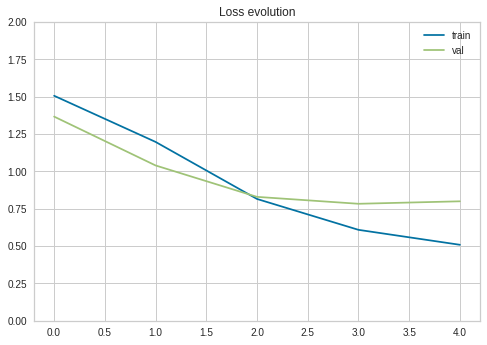

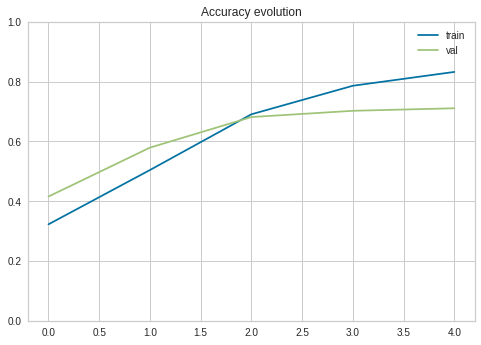

In [125]:
plot_history(history)

In [126]:
# Accuracy on the test set
print('accuracy {}'.format(round(accuracy_score(y_test, y_pred2), 4)))
print('f1 macro {}'.format(round(f1_score(y_test, y_pred2, average='weighted'), 4)))

accuracy 0.6746
f1 macro 0.6759


LSTM model without pre-trained embedding has an accuracy of 68% which is better than MLP. It also performs better than multinomial logistic model and random forest.